In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data_train = pd.read_csv('DailyDelhiClimateTrain.csv')
data_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
# check for null values
data_train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Text(0.5, 1.0, 'Temperature average')

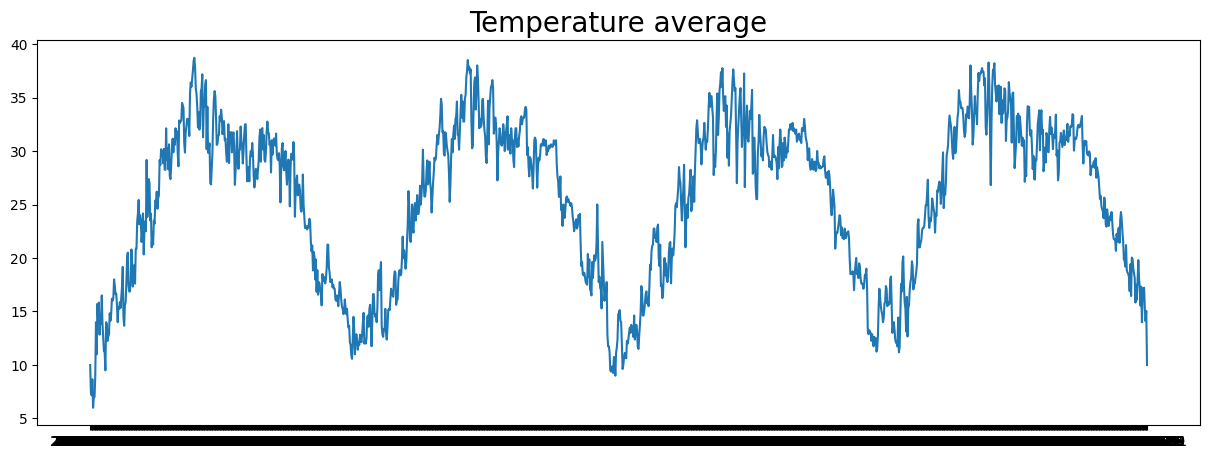

In [5]:
# make plot to determine data type
dates = data_train['date'].values
temp = data_train['meantemp'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average', fontsize=20)

In [6]:
# function to change atribute and label into batch
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [7]:
# create model LSTM
train_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
    LSTM(60, return_sequences=True),
    LSTM(60),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1)
])

In [8]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
)
history = model.fit(train_set, epochs=100)

Epoch 1/100
15/15 [==============================] - 6s 93ms/step - loss: 25.2247 - mae: 25.7247
Epoch 2/100
15/15 [==============================] - 2s 91ms/step - loss: 25.0781 - mae: 25.5781
Epoch 3/100
15/15 [==============================] - 2s 94ms/step - loss: 24.8878 - mae: 25.3878
Epoch 4/100
15/15 [==============================] - 2s 126ms/step - loss: 24.6726 - mae: 25.1726
Epoch 5/100
15/15 [==============================] - 2s 90ms/step - loss: 24.4362 - mae: 24.9362
Epoch 6/100
15/15 [==============================] - 2s 91ms/step - loss: 24.1675 - mae: 24.6675
Epoch 7/100
15/15 [==============================] - 2s 91ms/step - loss: 23.8538 - mae: 24.3538
Epoch 8/100
15/15 [==============================] - 2s 90ms/step - loss: 23.4538 - mae: 23.9538
Epoch 9/100
15/15 [==============================] - 2s 112ms/step - loss: 22.9371 - mae: 23.4371
Epoch 10/100
15/15 [==============================] - 3s 141ms/step - loss: 22.3487 - mae: 22.8487
Epoch 11/100
15/15 [======

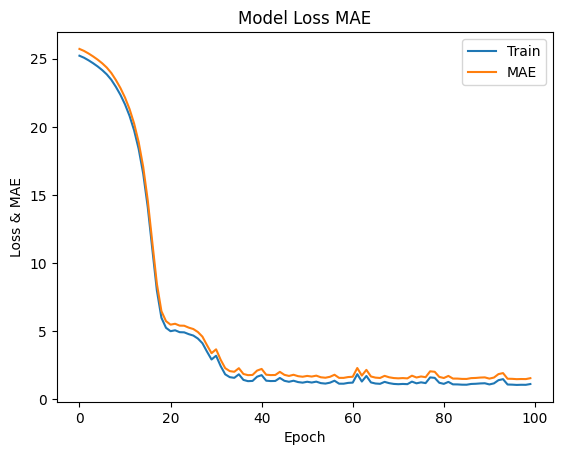

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['mae'])
plt.title('Model Loss MAE')
plt.ylabel('Loss & MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'MAE'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 68ms/step


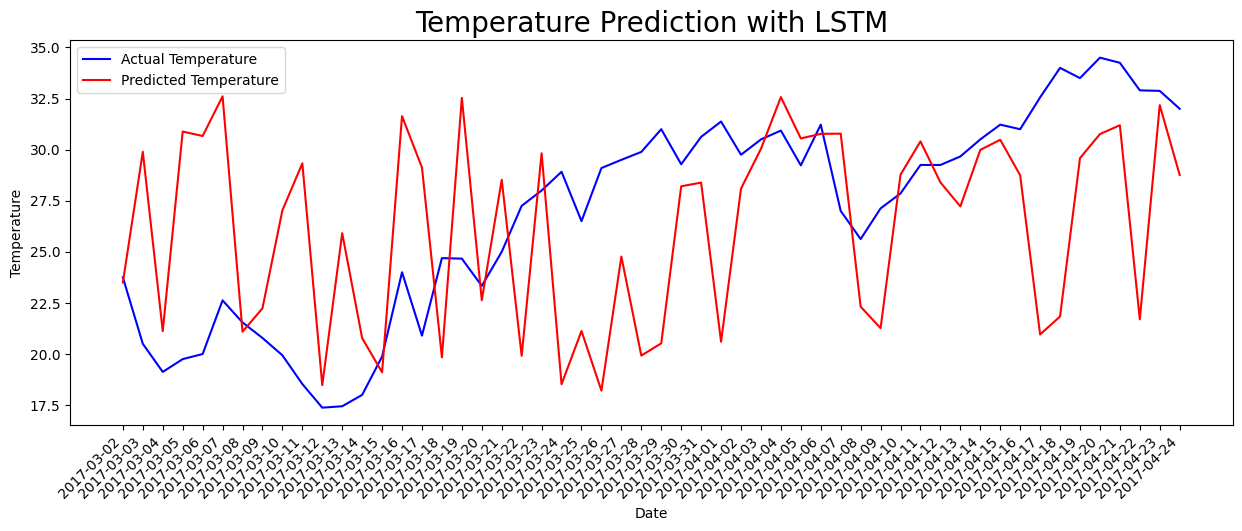

In [17]:
# predictions
data_test = pd.read_csv('DailyDelhiClimateTest.csv')

date_test = data_test['date'].values
temp_test = data_test['meantemp'].values

test_set = windowed_dataset(temp_test, window_size=60, batch_size=100, shuffle_buffer=1000)

predictions = model.predict(test_set)

plt.figure(figsize=(15,5))
plt.plot(date_test[60:], temp_test[60:], label='Actual Temperature', color='blue')
plt.plot(date_test[60:], predictions, label='Predicted Temperature', color='red')
plt.title('Temperature Prediction with LSTM', fontsize=20)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()